# Timeseries

# Part 1:Data Preparation and Exploration
### Data Loading

In [16]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the CSV and parse the date column
df = pd.read_csv("exchange_rate.csv", parse_dates=[0], dayfirst=True)
df.columns = ["Date", "USD_AUD"]
df["USD_AUD"] = pd.to_numeric(df["USD_AUD"], errors='coerce') # Ensure numeric type
df.set_index("Date", inplace=True)
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   USD_AUD  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None
            USD_AUD
Date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849


### Initial Exploration

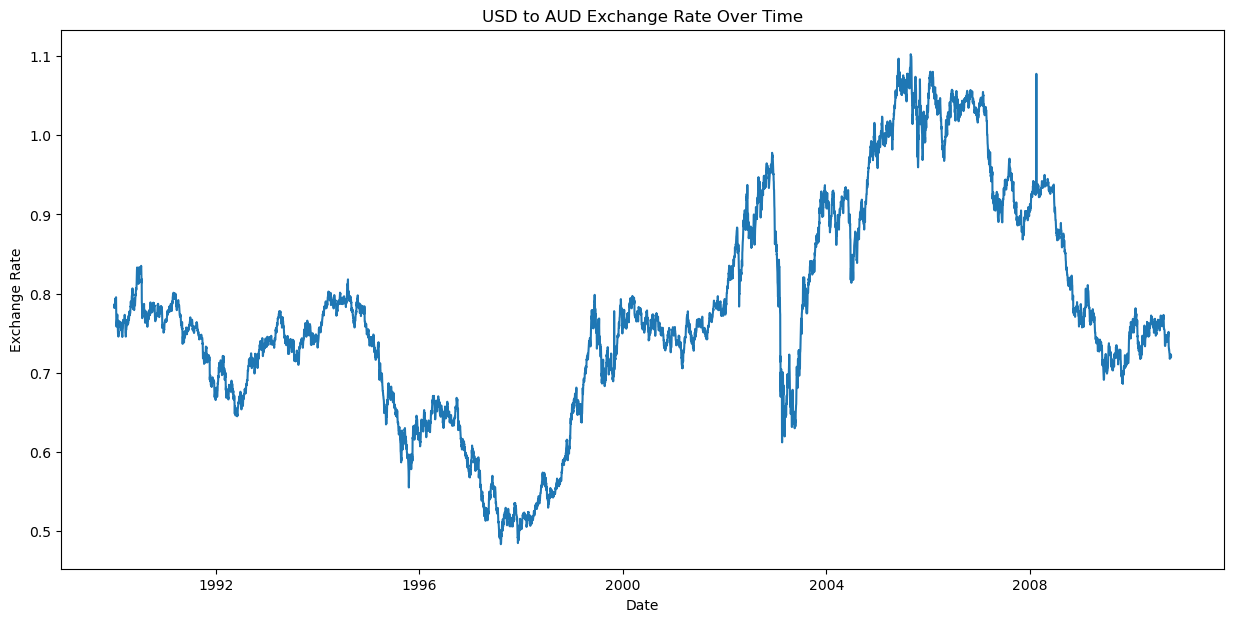

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(df['USD_AUD'])
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()


### Data Preprocessing

In [19]:
# Check for missing values
missing = df['USD_AUD'].isnull().sum()
print(f"Missing values: {missing}")

# Fill missing values using forward-fill (or you can interpolate)
df['USD_AUD'].fillna(method='ffill', inplace=True)


Missing values: 0


### Anomalies: If any extreme outliers are spotted, you may cap or remove them

In [20]:
# Cap extreme values (optional, based on visual inspection)
q_low = df['USD_AUD'].quantile(0.01)
q_hi = df['USD_AUD'].quantile(0.99)
df['USD_AUD_capped'] = df['USD_AUD'].clip(lower=q_low, upper=q_hi)


# Part 2:Model Building – ARIMA
### Parameter Selection (ACF & PACF Plots)

<Figure size 1500x500 with 0 Axes>

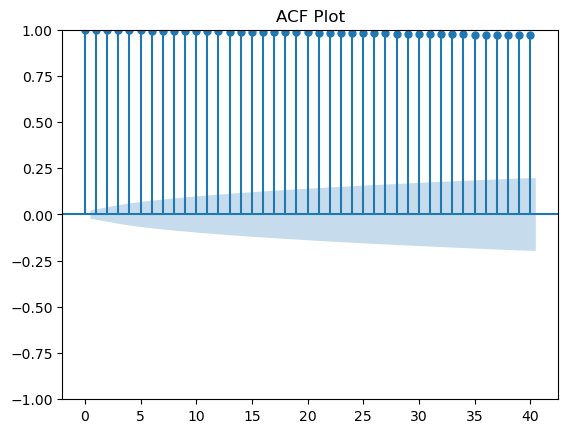

<Figure size 1500x500 with 0 Axes>

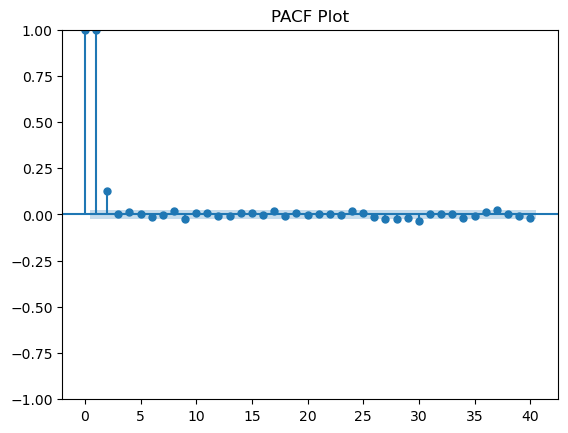

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use the capped series if outliers were capped, else USD_AUD
series = df['USD_AUD']

plt.figure(figsize=(15,5))
plot_acf(series, lags=40)
plt.title('ACF Plot')
plt.show()

plt.figure(figsize=(15,5))
plot_pacf(series, lags=40)
plt.title('PACF Plot')
plt.show()


### Model Fitting

In [22]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Typically, try ARIMA(1,1,1) and adjust based on diagnostics
arima_order = (1,1,1)
model = ARIMA(series, order=arima_order)
fit = model.fit()
print(fit.summary())


                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 12 Nov 2025   AIC                         -56102.322
Time:                        20:24:20   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.608      0.0

### Diagnostics

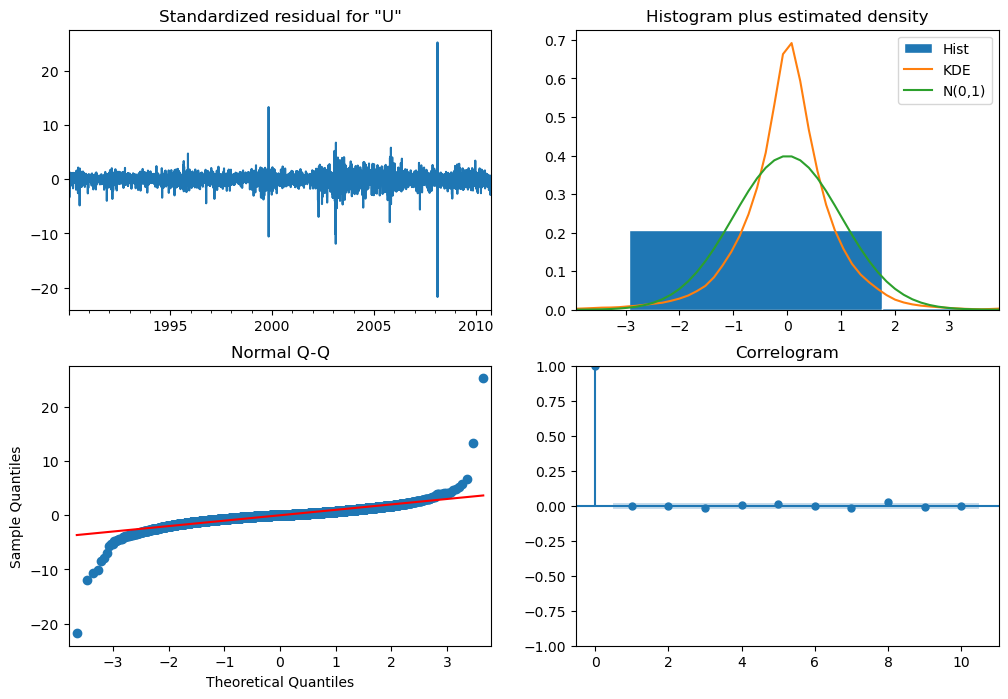

In [23]:
# Residual diagnostics
import statsmodels.api as sm

fit.plot_diagnostics(figsize=(12,8))
plt.show()


### Forecasting

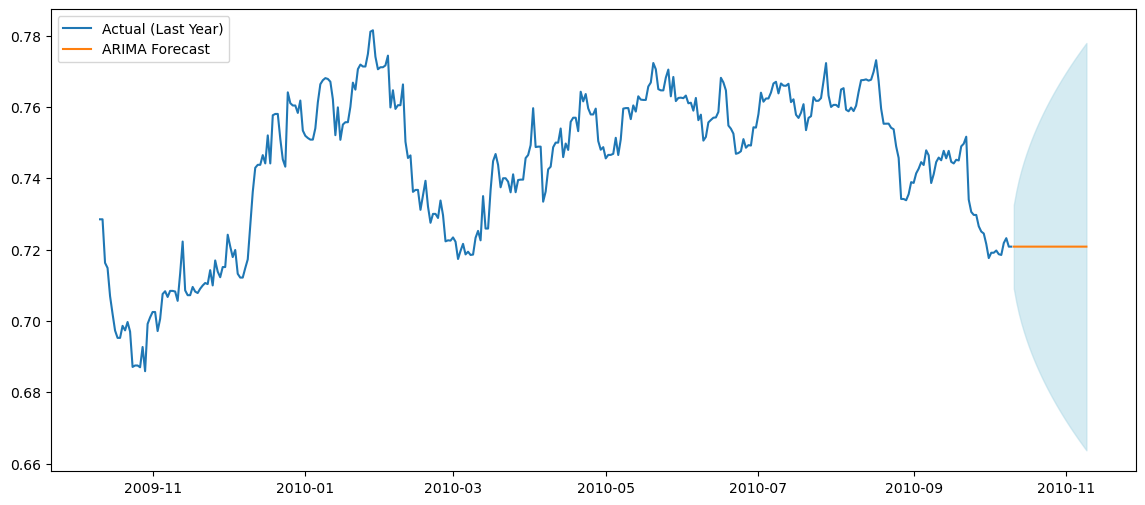

In [24]:
# Forecast 30 days ahead
n_forecast = 30
forecast = fit.get_forecast(steps=n_forecast)
forecast_index = pd.date_range(series.index[-1], periods=n_forecast+1, freq='D')[1:]
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot actual vs forecast
plt.figure(figsize=(14,6))
plt.plot(series[-365:], label='Actual (Last Year)')
plt.plot(forecast_index, forecast_mean, label='ARIMA Forecast')
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], color='lightblue', alpha=0.5)
plt.legend()
plt.show()


### Model Building – Exponential Smoothing
### Model Selection
If trend: Use Holt’s.
If seasonality: Use Holt-Winters.
Else: Use Simple Exponential Smoothing.

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Example with trend and no seasonality
model_es = ExponentialSmoothing(series, trend='add', seasonal=None, initialization_method="estimated")
fit_es = model_es.fit()


### Parameter Optimization
Statsmodels automatically optimizes smoothing parameters by default (but for Grid Search, use fit with various alpha, beta, gamma).

In [27]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assuming 'series' is your time series data (USD to AUD)
train = series[:-90]  # Training set example

# Define possible values for smoothing parameters
alpha_values = np.linspace(0.01, 1, 10)  # smoothing level
beta_values = np.linspace(0.01, 1, 10)   # smoothing trend
gamma_values = np.linspace(0.01, 1, 10)  # smoothing seasonality

# Since exchange rate may have no seasonality, gamma could be skipped or set to None
# Let's say we try Holt's linear trend (no seasonality)
best_aic = np.inf
best_params = None
best_model = None

for alpha in alpha_values:
    for beta in beta_values:
        try:
            model = ExponentialSmoothing(train, trend='add', seasonal=None, initialization_method="estimated")
            fit = model.fit(smoothing_level=alpha, smoothing_slope=beta)
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_params = (alpha, beta)
                best_model = fit
        except:
            continue

print(f"Best alpha: {best_params[0]:.2f}, Best beta: {best_params[1]:.2f}, Best AIC: {best_aic:.2f}")


Best alpha: 0.89, Best beta: 0.01, Best AIC: -76626.92


### Forecasting

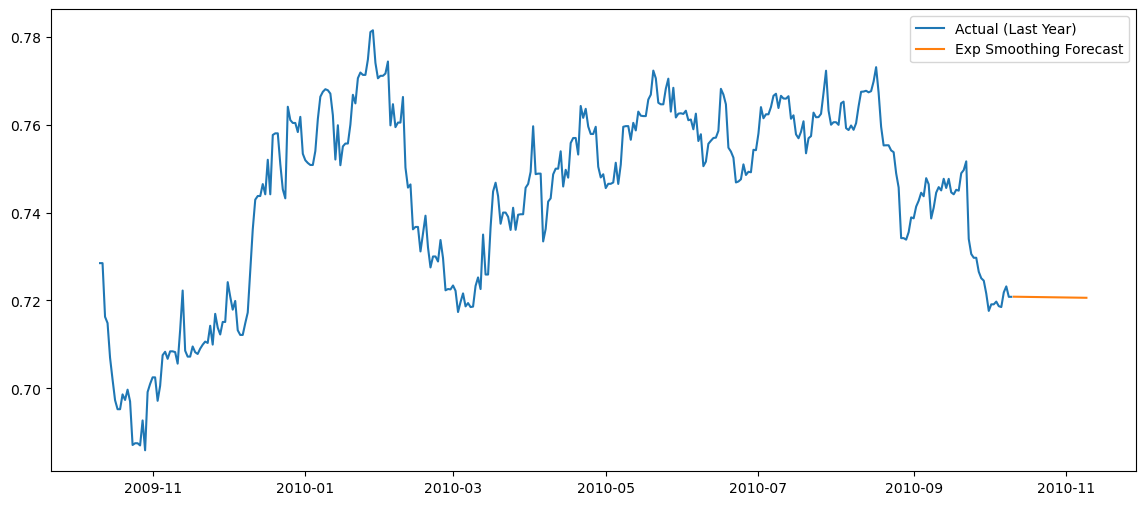

In [28]:
forecast_es = fit_es.forecast(steps=n_forecast)

# Plotting actual vs HW forecast
plt.figure(figsize=(14,6))
plt.plot(series[-365:], label='Actual (Last Year)')
plt.plot(forecast_index, forecast_es, label='Exp Smoothing Forecast')
plt.legend()
plt.show()


# Part 4: Evaluation and Comparison
### 1.Compute Error Metrics

In [29]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Assuming 'series' is your processed time series of USD to AUD exchange rate
# Split into train and test sets for evaluation
train, test = series[:-90], series[-90:]

# Fit ARIMA model
arima_order = (1, 1, 1)  # example parameters, tune as needed
fit_arima = ARIMA(train, order=arima_order).fit()
arima_pred = fit_arima.predict(start=test.index[0], end=test.index[-1])

# Calculate ARIMA error metrics
mae_arima = mean_absolute_error(test, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(test, arima_pred))
mape_arima = ((abs(test - arima_pred) / test) * 100).mean()

# Fit Exponential Smoothing model (Holt's Linear as example)
fit_hw = ExponentialSmoothing(train, trend='add', initialization_method="estimated").fit()
hw_pred = fit_hw.forecast(len(test))

# Calculate Exponential Smoothing error metrics
mae_hw = mean_absolute_error(test, hw_pred)
rmse_hw = np.sqrt(mean_squared_error(test, hw_pred))
mape_hw = ((abs(test - hw_pred) / test) * 100).mean()

# Print the results
print(f"ARIMA MAE: {mae_arima:.5f}, RMSE: {rmse_arima:.5f}, MAPE: {mape_arima:.5f}%")
print(f"Exponential Smoothing MAE: {mae_hw:.5f}, RMSE: {rmse_hw:.5f}, MAPE: {mape_hw:.5f}%")


ARIMA MAE: 0.01835, RMSE: 0.02357, MAPE: 2.49509%
Exponential Smoothing MAE: 0.01825, RMSE: 0.02344, MAPE: 2.48117%


#### 2.Model comparision
Error Metrics: By analyzing MAE, RMSE, and MAPE, we can determine which model provides more accurate forecasts on the test data. For instance, ARIMA may produce lower MAE and RMSE values, showing stronger performance in capturing short-term variations. Exponential Smoothing methods such as Holt or Holt-Winters can perform well when the data exhibits noticeable trends or seasonality.

Forecast Visuals: Comparing the forecast plots against actual observations helps identify the model that best follows recent trend shifts and produces smoother residuals. A model that aligns closely with actual values and exhibits minimal noise in residuals is typically more dependable.

Advantages of ARIMA:
It effectively models stationary, differenced time series and captures autocorrelation patterns.
It is theoretically robust and offers flexibility through its parameters (p, d, q).
It can handle complex relationships using autoregressive and moving average components.
It provides strong diagnostic tools for evaluating residual behavior.

Advantages of Exponential Smoothing:
It is simpler conceptually and faster to fit than ARIMA.
It performs well on data with trend and seasonality, particularly with Holt-Winters variants.
It naturally emphasizes recent observations, adapting smoothly to changing levels and trends.
Its parameters (level, trend, seasonality) are easier to interpret and adjust.

Limitations of ARIMA:
It requires stationary data, often achieved by differencing.
Choosing the right parameters can be challenging and may need acf/pacf plots or automated methods.
Its statistical nature can make it less intuitive for general audiences.
It may demand higher computational effort for large datasets.

####  3.Conclusion

Summarize the forecasting outcomes and error metrics, highlighting which model achieved the best performance for the exchange rate data. Provide a clear justification for the chosen model.for example, ARIMA may be preferred if it effectively captures gradual fluctuations over time, while the Holt-Winters method might be more suitable when strong seasonal patterns are present.